In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime

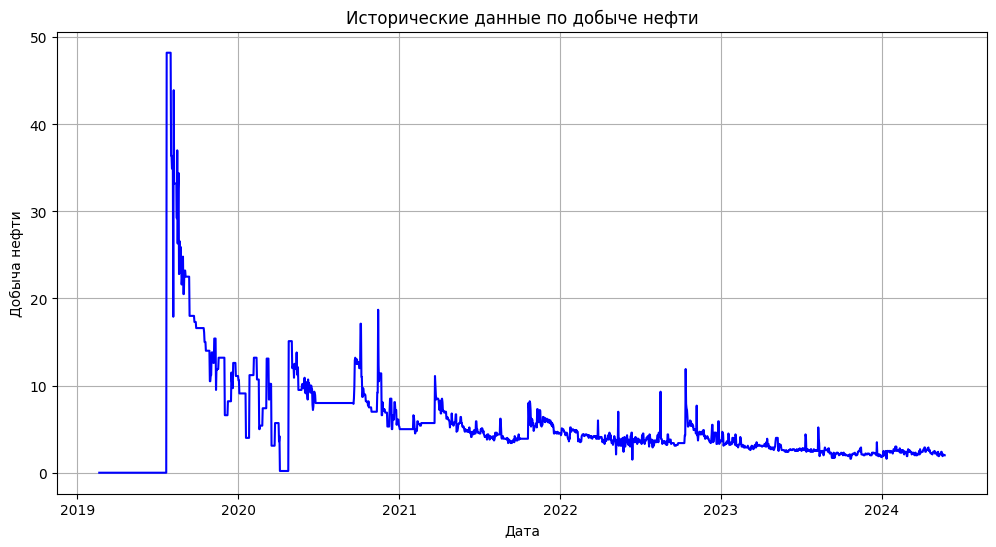

In [28]:
# Загрузка данных из CSV-файла
# Важно: файл должен содержать два столбца: Date (в формате DD.MM.YYYY) и Production (дебит нефти)
# Разделитель - точка с запятой
data = pd.read_csv('Production.csv', sep=';', parse_dates=['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

# Сортируем данные по дате
data = data.sort_index()

# Визуализация исходных данных
plt.figure(figsize=(12, 6))
plt.plot(data['Production'], color='b')
plt.title('Исторические данные по добыче нефти')
plt.xlabel('Дата')
plt.ylabel('Добыча нефти')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Начало обучения модели...
Epoch 1/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 686ms/step - loss: 0.0120
Epoch 2/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 716ms/step - loss: 0.0023
Epoch 3/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 675ms/step - loss: 0.0027
Epoch 4/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 635ms/step - loss: 0.0050
Epoch 5/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 700ms/step - loss: 0.0015
Epoch 6/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 709ms/step - loss: 0.0016
Epoch 7/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 687ms/step - loss: 0.0021
Epoch 8/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 688ms/step - loss: 0.0020
Epoch 9/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 681ms/step - loss: 0.0016
Epoch 10/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 662ms/step - loss: 0.0037
Epoch 11/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 659ms/step - loss: 0.0018
Epoch 12/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 688ms/step - loss: 0.0016
Epoch 13/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - loss: 0.0011
Epoch 14/45
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - loss: 0.0019
Epoch 15/45
45/45

<ipython-input-29-cefbfd8619bb>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


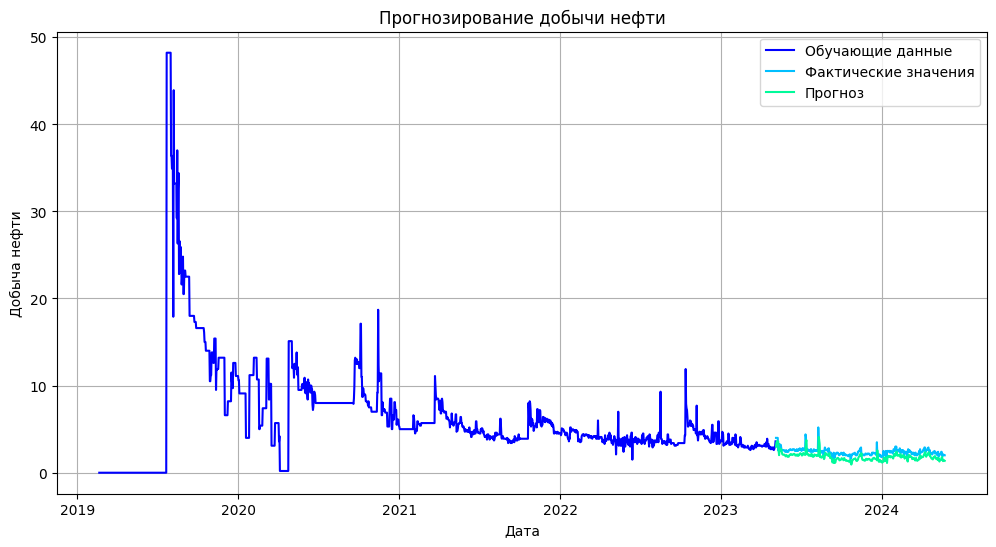

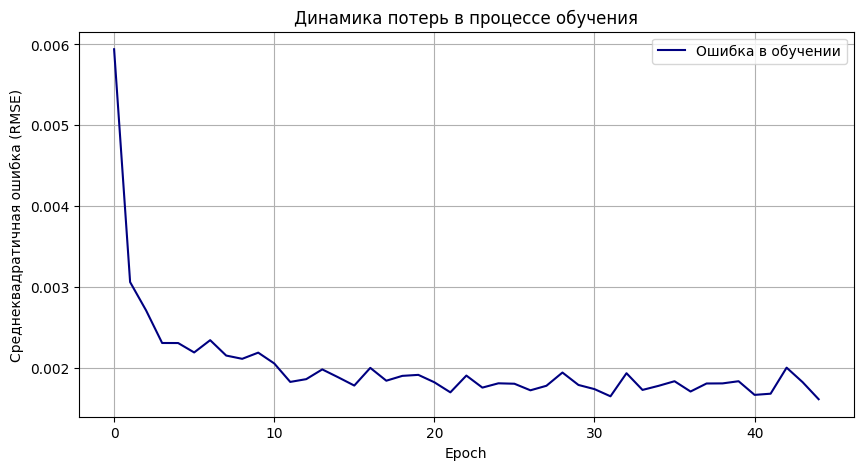

In [29]:
# Преобразование данных в массив значений
dataset = data.values

# Определение длины обучающей выборки
train_data_len = int(np.ceil(len(dataset) * 0.8))

# Нормализация данных (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Создание обучающего набора данных
train_data = scaled_data[0:train_data_len, :]

# Подготовка последовательностей для обучения
x_train = []
y_train = []

# Используем окно в sequence_length дней для прогнозирования следующего значения
sequence_length = 100

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

# Преобразование в numpy массивы
x_train, y_train = np.array(x_train), np.array(y_train)

# Изменение формы данных для LSTM [образцы, временные шаги, признаки]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Создание модели LSTM
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
print("Начало обучения модели...")
history = model.fit(x_train, y_train, batch_size=32, epochs=45)
print("Обучение завершено!")

# Подготовка тестовых данных
test_data = scaled_data[train_data_len - sequence_length:, :]
x_test = []
y_test = dataset[train_data_len:, :]

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

# Преобразование тестовых данных
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Прогнозирование на тестовых данных
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Подготовка данных для визуализации
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

# Метрики качества модели
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.title('Прогнозирование добычи нефти')
plt.xlabel('Дата')
plt.ylabel('Добыча нефти')
plt.plot(train['Production'], color='b', label='Обучающие данные')
plt.plot(valid['Production'], color='deepskyblue', label='Фактические значения')
plt.plot(valid['Predictions'], color='mediumspringgreen', label='Прогноз')
plt.legend()
plt.grid(True)
plt.show()

# График процесса обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color='navy', label='Ошибка в обучении')
plt.title('Динамика потерь в процессе обучения')
plt.ylabel('Среднеквадратичная ошибка (RMSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


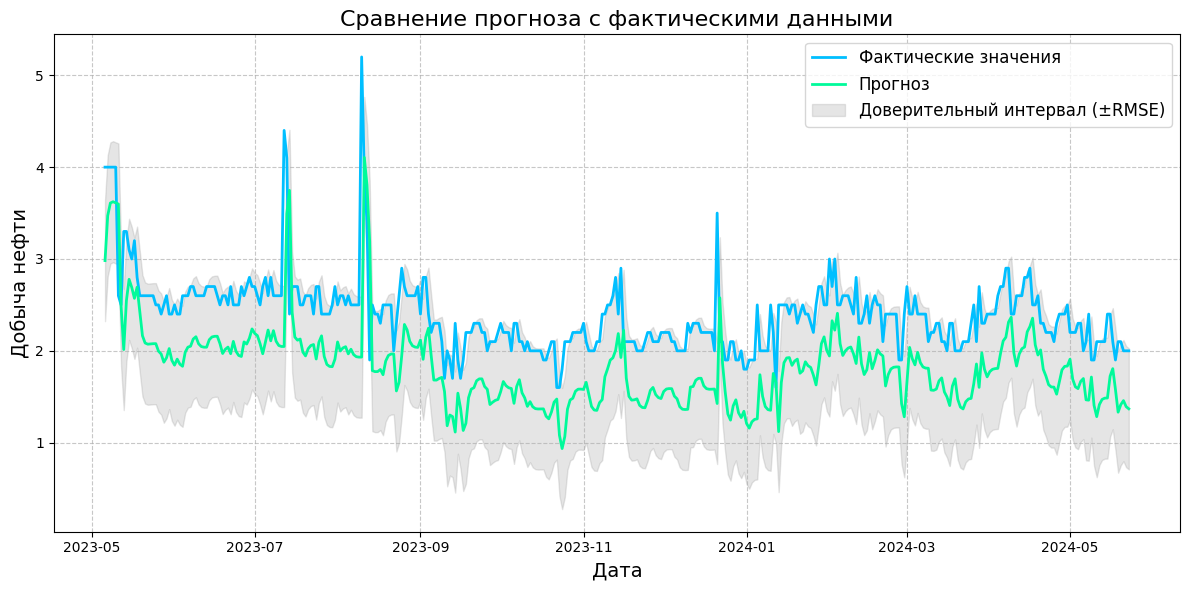

In [31]:
# Подробный график сравнения прогноза с фактом
plt.figure(figsize=(12, 6))
plt.plot(valid.index, valid['Production'], color='deepskyblue', label='Фактические значения', linewidth=2)
plt.plot(valid.index, valid['Predictions'], color='mediumspringgreen', label='Прогноз', linewidth=2)
plt.fill_between(valid.index,
                 valid['Predictions'] - rmse,
                 valid['Predictions'] + rmse,
                 color='gray', alpha=0.2, label='Доверительный интервал (±RMSE)')
plt.title('Сравнение прогноза с фактическими данными', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Добыча нефти', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

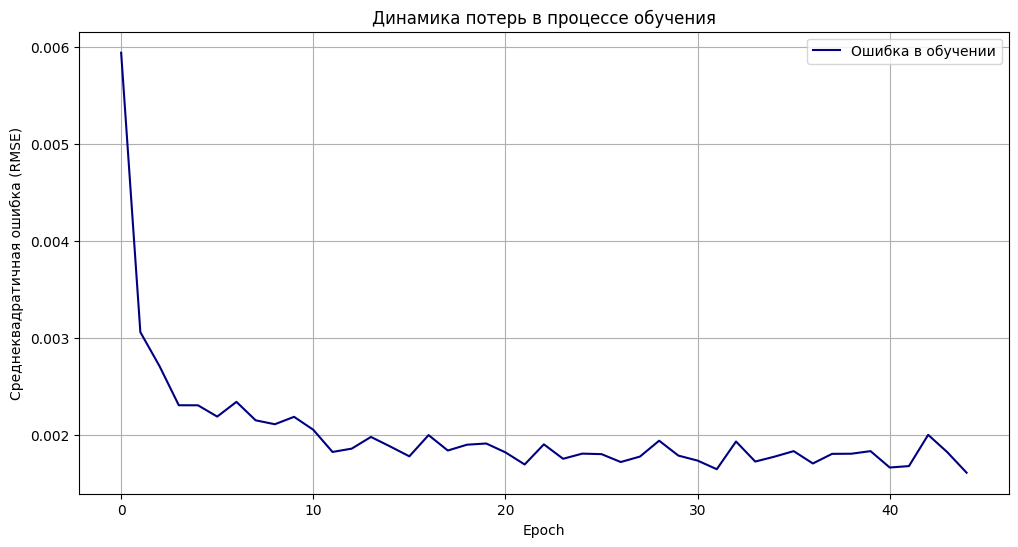

In [32]:
# График процесса обучения
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], color='navy', label='Ошибка в обучении')
plt.title('Динамика потерь в процессе обучения')
plt.ylabel('Среднеквадратичная ошибка (RMSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

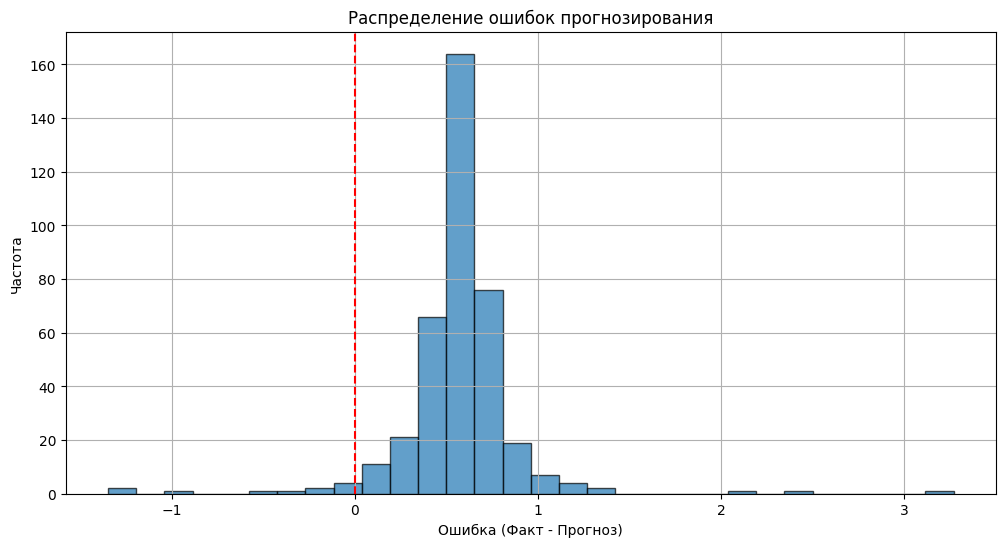

In [33]:
# График распределения ошибок
errors = y_test.flatten() - predictions.flatten()
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Распределение ошибок прогнозирования')
plt.xlabel('Ошибка (Факт - Прогноз)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


Оценка качества модели:
RMSE (Среднекв. ошибка): 0.66
MAE (Средняя абс. ошибка): 0.60


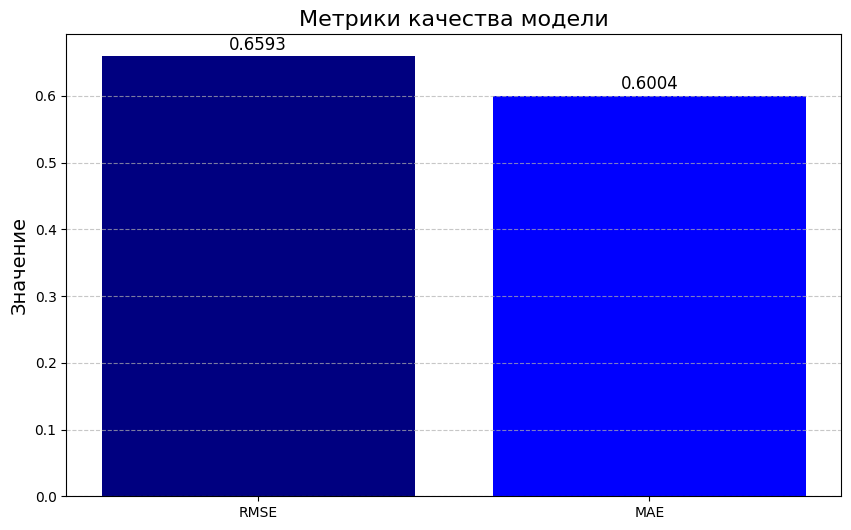

In [34]:
# Метрики качества модели

print("\nОценка качества модели:")
print(f"RMSE (Среднекв. ошибка): {rmse:.2f}")
print(f"MAE (Средняя абс. ошибка): {mae:.2f}")

metrics = {
    'RMSE': rmse,
    'MAE': mae
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['navy', 'blue'])
plt.title('Метрики качества модели', fontsize=16)
plt.ylabel('Значение', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений на столбцы
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.show()

In [21]:
# Создать DataFrame с результатами
results = pd.DataFrame({
    'Фактические': valid['Production'],
    'Пронозируемые': valid['Predictions'],
    'Разность': valid['Production'] - valid['Predictions']
})

print("Результаты прогнозирования:")
print(results)


Результаты прогнозирования:
            Фактические  Пронозируемые  Разность
Date                                            
2023-05-06          4.0       4.242976 -0.242976
2023-05-07          4.0       4.668401 -0.668401
2023-05-08          4.0       4.773339 -0.773339
2023-05-09          4.0       4.777340 -0.777340
2023-05-10          4.0       4.762252 -0.762252
...                 ...            ...       ...
2024-05-19          2.1       2.823061 -0.723061
2024-05-20          2.1       2.909170 -0.809170
2024-05-21          2.0       2.947132 -0.947132
2024-05-22          2.0       2.884853 -0.884853
2024-05-23          2.0       2.864838 -0.864838

[384 rows x 3 columns]
